# Part 1: Reproducibility in phantom across all sites

## Before starting 

We import the main libraries we'll use:

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
import scipy.stats as stats

## Figure 1

First, we define the NiCl2 concentration in the different spheres of the T1 mimics compartment in the phantom (Data read in the phantom specs):

In [18]:
# Concentration data
CONC_NICL2 = {
    1: 0.29, 2: 0.6, 3: 1.04, 4: 1.64, 5: 2.52, 6: 3.68, 7: 5.43,
    8: 7.74, 9: 11.3, 10: 16.5, 11: 23.3, 12: 32.7, 13: 46, 14: 65.3
}

def get_nicl2_list():
    nvials = 14
    vial_num = np.arange(1, nvials + 1)
    conc = [CONC_NICL2[x] for x in vial_num]
    return conc

Then we proceed to read the data from the .csv files of each site. Check first your paths and then extract the T1 values for the sphres in the T1 mimics compartment, reconstructed with a Locally Low-Rank (LLR) approach:

In [19]:
# File paths and hospital names
file_paths = [
    r'C:\path\to\Cardiff_phantom_stats.csv',
    r'C:\path\to\Leiden_phantom_stats.csv',
    r'C:\path\to\London1_phantom_stats.csv',
    r'C:\path\to\London2_phantom_stats.csv',
    r'C:\path\to\Lund_phantom_stats.csv',
    r'C:\path\to\Vancouver_phantom_stats.csv'
]
hospital_names = ['Cardiff','Leiden','London 1','London 2','Lund','Vancouver']

def extract_tube_statistics(file_path):
    """Extracts T1 statistics from the given file."""
    columns_to_read = ['LabelValue', 'Mean', 'Variance', 'Quant', 'Segmentation', 'Reconstruction']
    df = pd.read_csv(file_path, usecols=columns_to_read)
    
    # Filter rows based on reconstruction, quantification, and segmentation criteria
    df_filtered = df.query("Reconstruction == 'LLRv1' and Quant == 'T1' and Segmentation == 'T1mimics'")
    
    # Store means for each tube
    tube_stats = {tube: df_filtered.loc[df_filtered['LabelValue'] == tube, 'Mean'].values
                  for tube in df_filtered['LabelValue'].unique()}
    
    return tube_stats

Then we proceed to plot them and fit the relaxivities, limited to T1 between 100 and 1000 ms, for which the T1 mapping protocol was optimized:

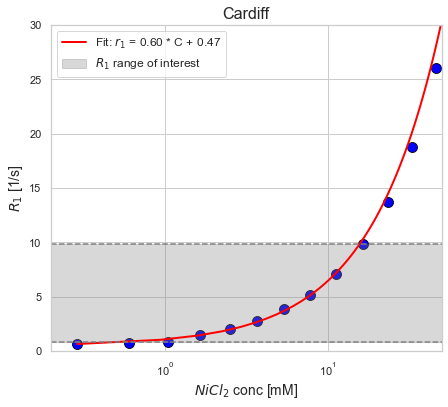

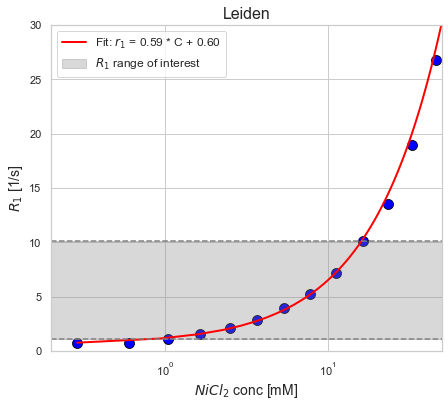

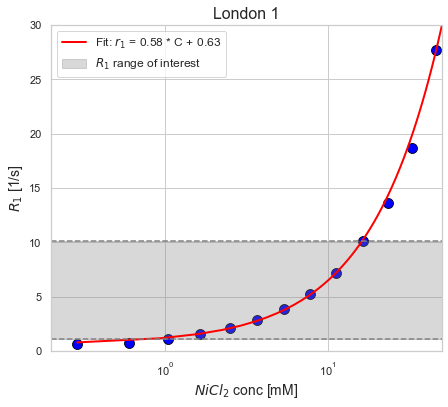

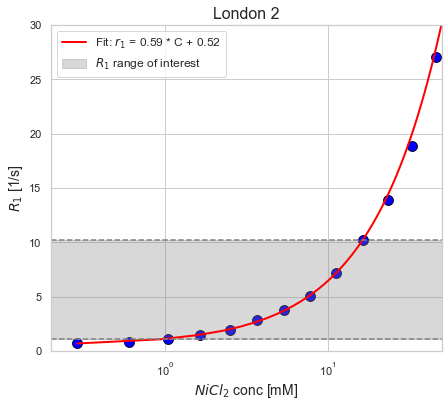

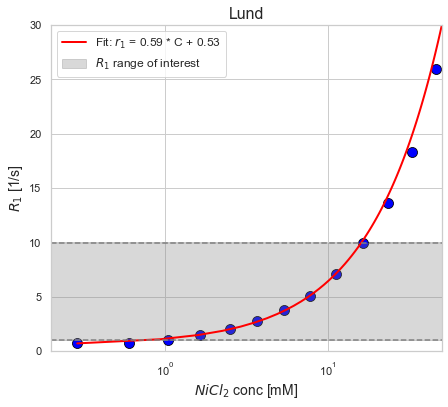

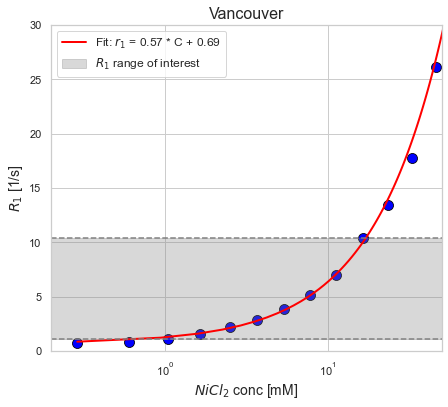

In [6]:
# Extract data for all hospitals
hospital_results = {hospital_name: extract_tube_statistics(file_path)
                    for file_path, hospital_name in zip(file_paths, hospital_names)}

# Prepare NiCl2 concentrations
concentrations = get_nicl2_list()

# Iterate over each hospital to generate plots
for hospital_name, hospital_data in hospital_results.items():
    means = []
    # Process the data for the current hospital
    for tube in hospital_data.keys():
        means.append(1 / np.mean(hospital_data[tube]))

    # Select the central 5 tubes for fitting (from tube 3 to tube 9)
    x_central = concentrations[2:9]
    y_central = means[2:9]

    # Fit a linear model to the selected central tubes
    slope, intercept = np.polyfit(x_central, y_central, 1)

    # Create fitted line
    x_fit = np.linspace(min(concentrations), max(concentrations), 100)
    y_fit = slope * x_fit + intercept

    # Create the plot
    sns.set(style="whitegrid")
    plt.figure(figsize=(7, 6))
    sns.scatterplot(x=concentrations, y=means, color='blue', s=100, edgecolor='black')
    plt.plot(x_fit, y_fit, color='red', linestyle='-', linewidth=2, label=f'Fit: $r_1$ = {slope:.2f} * C + {intercept:.2f}')
    plt.axhline(y=means[2], color='grey', linestyle='--')
    plt.axhline(y=means[9], color='grey', linestyle='--')
    plt.fill_betweenx([means[2], means[9]], 0.2, max(concentrations) + 10, color='grey', alpha=0.3, label='$R_1$ range of interest')
    plt.xscale('log')
    plt.xlabel('$NiCl_2$ conc [mM]', fontsize=14)
    plt.ylabel('$R_1$ [1/s]', fontsize=14)
    plt.title(f'{hospital_name}', fontsize=16)
    plt.legend(fontsize=12)
    plt.xlim([0.2, 50])
    plt.ylim([0, 30])
    plt.show()

# Figure 2

Extract the T1 values for Tube 6 and 7 in the T1 mimics spheres, 

In [23]:
def extract_tube_statistics(file_path, hospital_name):
    columns_to_read = ['LabelValue', 'Mean', 'Variance', 'Quant', 'Segmentation', 'Reconstruction']
    if hospital_name == 'Lund':
        columns_to_read.append('Session')  # Include session column for filtering

    df = pd.read_csv(file_path, usecols=columns_to_read)
    df_filtered = df.query("Reconstruction == 'LLRv1' and Quant == 'T1' and Segmentation == 'T1mimics'")

    structure_df = df_filtered[df_filtered['LabelValue'].isin([6, 7])]
    means_tube_6 = structure_df.loc[structure_df['LabelValue'] == 6, 'Mean'].values
    variances_tube_6 = structure_df.loc[structure_df['LabelValue'] == 6, 'Variance'].values
    
    means_tube_7 = structure_df.loc[structure_df['LabelValue'] == 7, 'Mean'].values
    variances_tube_7 = structure_df.loc[structure_df['LabelValue'] == 7, 'Variance'].values

    return {
        'means_tube_6': means_tube_6,
        'variances_tube_6': variances_tube_6,
        'means_tube_7': means_tube_7,
        'variances_tube_7': variances_tube_7
    }

Plot the data:

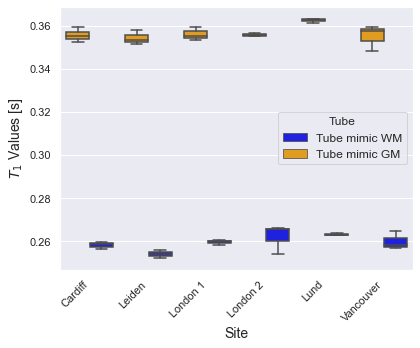

In [24]:
# Extract data
hospital_results = {}
for file_path, hospital_name in zip(file_paths, hospital_names):
    result = extract_tube_statistics(file_path, hospital_name)
    hospital_results[hospital_name] = result

# Prepare data for plotting
data = []
for hospital, stats in hospital_results.items():
    for tube in ['Tube 6', 'Tube 7']:
        means = stats['means_tube_6'][-3:] if tube == 'Tube 6' else stats['means_tube_7'][-3:]
        
        # Add each mean to the dataframe
        for mean in means:
            data.append({
                'Hospital': hospital,
                'Tube': tube,
                'Mean': mean
            })
df = pd.DataFrame(data)

# Sort the dataframe by hospital name
df = df.sort_values(by='Hospital')

# Plotting 
plt.figure(figsize=(6,5))
palette = {'Tube 6': 'orange', 'Tube 7': 'blue'}
ax = sns.boxplot(data=df, x='Hospital', y='Mean', hue='Tube', palette=palette, order=sorted(df['Hospital'].unique()))
plt.xlabel('Site', fontsize=14)
plt.ylabel('$T_1$ Values [s]', fontsize=14)
plt.xticks(rotation=45, ha='right')
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = {'Tube 7': 'Tube mimic WM', 'Tube 6': 'Tube mimic GM'}
new_handles = [handles[labels.index(key)] for key in new_labels]
plt.legend(new_handles, [new_labels[key] for key in new_labels], title='Tube', fontsize=12)
plt.tight_layout()
plt.show()


Perform the ANOVA test:

In [25]:
# Perform ANOVA for Tube 6
anova_tube_6 = f_oneway(*tube_6_data)
print(f"ANOVA results for Tube 6: F-statistic = {anova_tube_6.statistic:.4f}, p-value = {anova_tube_6.pvalue:.4f}")

# Perform ANOVA for Tube 7
anova_tube_7 = f_oneway(*tube_7_data)
print(f"ANOVA results for Tube 7: F-statistic = {anova_tube_7.statistic:.4f}, p-value = {anova_tube_7.pvalue:.4f}")


ANOVA results for Tube 6: F-statistic = 2.2888, p-value = 0.1114
ANOVA results for Tube 7: F-statistic = 2.5363, p-value = 0.0866


# Figure S3

To plot this graph, we need to read the excel file "PhantomTemperature.xlsx", where the T1 and temperature recorded at each site are saved. To generate part a., we use:

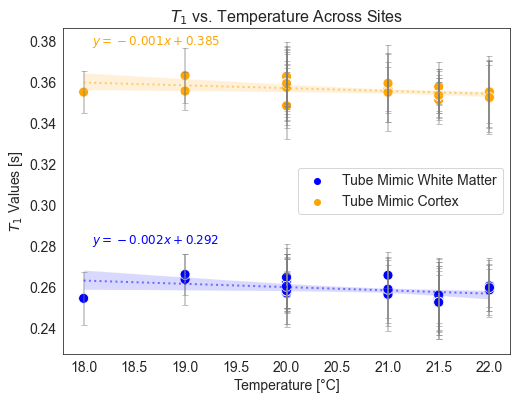

In [11]:
# Load the Excel file
file_path = r'..\..\path\to\PhantomTemperatures.xlsx'
df = pd.read_excel(file_path, sheet_name="Sheet2")


# Reshape data for better plotting
df_melted = df.melt(id_vars=['Site', 'Temperature'], value_vars=['T1-WM', 'T1-GM'], var_name='Tube', value_name='T1')
df_std = df.melt(id_vars=['Site', 'Temperature'], value_vars=['std-T1-WM', 'std-T1-GM'], var_name='Tube', value_name='T1_std')
df_std['Tube'] = df_std['Tube'].replace({'std-T1-WM': 'T1-WM', 'std-T1-GM': 'T1-GM'})
df_melted = df_melted.merge(df_std, on=['Site', 'Temperature', 'Tube'], how='left')

# Define color palette for Tube categories
palette = {'T1-WM': 'blue', 'T1-GM': 'orange'}

# Function to add regression line and equation
def add_regression_line(df, tube_label, color):
    slope, intercept, _, _, _ = stats.linregress(df['Temperature'], df['T1'])
    
    # Plot regression line 
    sns.regplot(data=df, x='Temperature', y='T1', scatter=False, line_kws={'color': color, 'lw': 2, 'alpha': 0.5, 'linestyle': ':'})
    
    # Equation formatting
    equation = f"$y = {slope:.3f}x + {intercept:.3f}$"
    x_pos = df['Temperature'].min() + (df['Temperature'].max() - df['Temperature'].min()) * 0.02
    y_pos = df['T1'].max() + 0.015
    plt.text(x=x_pos, y=y_pos, s=equation, color=color, fontsize=12)

# Plot Temperature vs. T1 with regression lines and equations
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_melted, x='Temperature', y='T1', hue='Tube', palette=palette, s=100)

add_regression_line(df_melted[df_melted['Tube'] == 'T1-WM'], 'T1-WM', 'blue')
add_regression_line(df_melted[df_melted['Tube'] == 'T1-GM'], 'T1-GM', 'orange')

# Add error bars
for _, row in df_melted.iterrows():
    plt.errorbar(row['Temperature'], row['T1'], yerr=row['T1_std'], fmt='none', ecolor='gray', alpha=0.5, capsize=3)


sns.set_style('white')
plt.xlabel('Temperature [°C]', fontsize=14)
plt.ylabel('$T_1$ Values [s]', fontsize=14)
plt.title('$T_1$ vs. Temperature Across Sites', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
handles, labels = plt.gca().get_legend_handles_labels()
labels = ['Tube Mimic White Matter', 'Tube Mimic Cortex']
plt.legend(handles, labels, fontsize=14)
plt.show()

And to generate part b. we use:

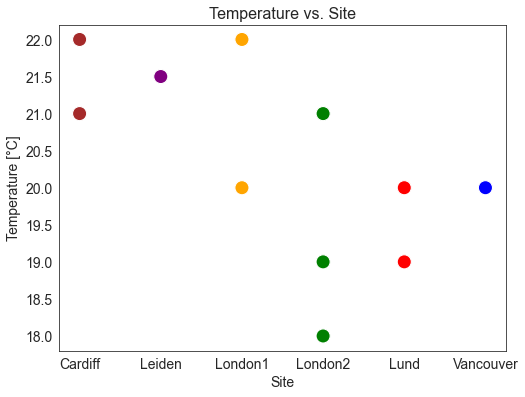

In [12]:
# Create a custom color palette for the sites
site_palette = {
    'Lund': 'red',
    'Vancouver': 'blue',
    'London2': 'green',
    'Leiden': 'purple',
    'London1': 'orange',
    'Cardiff': 'brown'
}

# Define the correct alphabetical order for sites
site_order = sorted(site_palette.keys())

# Convert 'Site' to a categorical variable with the specified order
df_melted['Site'] = pd.Categorical(df_melted['Site'], categories=site_order, ordered=True)

# Plot Temperature vs. Site
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_melted, x='Site', y='Temperature', hue='Site', palette=site_palette, s=200)
plt.xlabel('Site', fontsize=14)
plt.ylabel('Temperature [°C]', fontsize=14)
plt.title('Temperature vs. Site', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend([], [], frameon=False)
plt.show()